# **Tropical Cyclone Severity Prediction**
## **Machine Learning Pipeline**
**Objective**: Predict the severity of tropical cyclones using historical storm data.

In [2]:
!pip install xgboost

In [6]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Display settings
pd.set_option('display.max_columns', None)


In [34]:

# Load dataset in chunks for memory efficiency
file_path = r"C:\Users\FAVOUR\Downloads\Project 3\Project 3\ibtracs.csv"  

# Load a small chunk of data to inspect its structure
chunk_size = 5000  # Load only 5000 rows at a time
df_chunk = pd.read_csv(file_path, nrows=chunk_size)

# Display dataset structure
df_chunk.info()
df_chunk.head()


C:\Users\FAVOUR\AppData\Local\Temp\ipykernel_7196\2439838159.py:6: DtypeWarning: Columns (1,2,8,9,14,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df_chunk = pd.read_csv(file_path, nrows=chunk_size)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 174 entries, SID to STORM_DIR
dtypes: int64(1), object(173)
memory usage: 6.6+ MB


,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,WMO_AGENCY,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG,USA_AGENCY,USA_ATCF_ID,USA_LAT,USA_LON,USA_RECORD,USA_STATUS,USA_WIND,USA_PRES,USA_SSHS,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,USA_R50_NE,USA_R50_SE,USA_R50_SW,USA_R50_NW,USA_R64_NE,USA_R64_SE,USA_R64_SW,USA_R64_NW,USA_POCI,USA_ROCI,USA_RMW,USA_EYE,TOKYO_LAT,TOKYO_LON,TOKYO_GRADE,TOKYO_WIND,TOKYO_PRES,TOKYO_R50_DIR,TOKYO_R50_LONG,TOKYO_R50_SHORT,TOKYO_R30_DIR,TOKYO_R30_LONG,TOKYO_R30_SHORT,TOKYO_LAND,CMA_LAT,CMA_LON,CMA_CAT,CMA_WIND,CMA_PRES,HKO_LAT,HKO_LON,HKO_CAT,HKO_WIND,HKO_PRES,KMA_LAT,KMA_LON,KMA_CAT,KMA_WIND,KMA_PRES,KMA_R50_DIR,KMA_R50_LONG,KMA_R50_SHORT,KMA_R30_DIR,KMA_R30_LONG,KMA_R30_SHORT,NEWDELHI_LAT,NEWDELHI_LON,NEWDELHI_GRADE,NEWDELHI_WIND,NEWDELHI_PRES,NEWDELHI_CI,NEWDELHI_DP,NEWDELHI_POCI,REUNION_LAT,REUNION_LON,REUNION_TYPE,REUNION_WIND,REUNION_PRES,REUNION_TNUM,REUNION_CI,REUNION_RMW,REUNION_R34_NE,REUNION_R34_SE,REUNION_R34_SW,REUNION_R34_NW,REUNION_R50_NE,REUNION_R50_SE,REUNION_R50_SW,REUNION_R50_NW,REUNION_R64_NE,REUNION_R64_SE,REUNION_R64_SW,REUNION_R64_NW,BOM_LAT,BOM_LON,BOM_TYPE,BOM_WIND,BOM_PRES,BOM_TNUM,BOM_CI,BOM_RMW,BOM_R34_NE,BOM_R34_SE,BOM_R34_SW,BOM_R34_NW,BOM_R50_NE,BOM_R50_SE,BOM_R50_SW,BOM_R50_NW,BOM_R64_NE,BOM_R64_SE,BOM_R64_SW,BOM_R64_NW,BOM_ROCI,BOM_POCI,BOM_EYE,BOM_POS_METHOD,BOM_PRES_METHOD,NADI_LAT,NADI_LON,NADI_CAT,NADI_WIND,NADI_PRES,WELLINGTON_LAT,WELLINGTON_LON,WELLINGTON_WIND,WELLINGTON_PRES,DS824_LAT,DS824_LON,DS824_STAGE,DS824_WIND,DS824_PRES,TD9636_LAT,TD9636_LON,TD9636_STAGE,TD9636_WIND,TD9636_PRES,TD9635_LAT,TD9635_LON,TD9635_WIND,TD9635_PRES,TD9635_ROCI,NEUMANN_LAT,NEUMANN_LON,NEUMANN_CLASS,NEUMANN_WIND,NEUMANN_PRES,MLC_LAT,MLC_LON,MLC_CLASS,MLC_WIND,MLC_PRES,USA_GUST,BOM_GUST,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,,Year,,,,,,,degrees_north,degrees_east,kts,mb,,,km,km,,,,degrees_north,degrees_east,,,kts,mb,1,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,mb,nmile,nmile,nmile,degrees_north,degrees_east,1,kts,mb,,nmile,nmile,,nmile,nmile,1,degrees_north,degrees_east,1,kts,mb,degrees_north,degrees_east,,kts,mb,degrees_north,degrees_east,,kts,mb,,nmile,nmile,,nmile,nmile,degrees_north,degrees_east,,kts,mb,1,mb,mb,degrees_north,degrees_east,,kts,mb,1,1,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,degrees_north,degrees_east,,kts,mb,1,1,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,mb,nmile,,,degrees_north,degrees_east,1,kts,mb,degrees_north,degrees_east,kts,mb,degrees_north,degrees_east,,kts,mb,degrees_north,degrees_east,,kts,mb,degrees_north,degrees_east,kts,mb,nmile,degrees_north,degrees_east,,kts,mb,degrees_north,degrees_east,,kts,mb,kts,kts,second,kts,second,ft,nmile,nmile,nmile,nmile,kts,degrees
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5,172.5,,,,main,647,647,O_________OO_O_,jtwc_sh,SH051980,-12.5,172.5,,,25,,-1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-12.5,172.5,TC,25,,-12.5,172.5,1,25,,,,,,,-12.5,172.5,TC,25,,,,,,,,,,,,,,,,,6,350
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.2,172.4,,,,main,653,653,P_________PP_P_,,SH051980,-12.2,172.4,,,25,,-1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-12.2,172.4,TC,25,,-12.2,172.5,1,,,,,,,,-12.2,172.4,TC,25,,,,,,,,,,,,,,,,,6,350
3,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9,172.4,,,,main,670,670,O_________OP_O_,jtwc_sh,SH051980,-11.9,172.4,,,25,,-1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-11.9,172.4,TC,25,,-12.0,172.4,1,,,,,,,,-11.9,172.4,TC,25,,,,,,,,,,,,,,,,,5,360
4,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 09:00:00,TS,-11.7,172.4,,,,main,682,682,P_________PP_P

In [35]:

# Drop duplicate header row if necessary
df_chunk = df_chunk.iloc[1:].reset_index(drop=True)

# Convert numerical columns to appropriate types
numeric_cols = ["LAT", "LON", "DIST2LAND", "LANDFALL", "STORM_SPEED", "STORM_DIR", "TD9636_STAGE"]
for col in numeric_cols:
    df_chunk[col] = pd.to_numeric(df_chunk[col], errors="coerce")

# Drop irrelevant columns as per project guidelines
cols_to_drop = ["index", "NAME", "NUMBER", "BASIN", "SUBBASIN", "WMO_WIND", "TD9636_WIND", 
                "WMO_AGENCY", "IFLAG", "TRACK_TYPE", "BOM_PRES_METHOD", "DS824_STAGE", "NEUMANN_CLASS"]
df_chunk = df_chunk.drop(columns=[col for col in cols_to_drop if col in df_chunk.columns])

# Check for missing values
df_chunk.isna().sum()


SID              0
SEASON           0
ISO_TIME         0
NATURE           0
LAT              0
                ..
USA_SEARAD_SE    0
USA_SEARAD_SW    0
USA_SEARAD_NW    0
STORM_SPEED      0
STORM_DIR        0
Length: 162, dtype: int64

C:\Users\FAVOUR\AppData\Local\Temp\ipykernel_7196\2488434564.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_chunk["TD9636_STAGE"], palette="viridis")


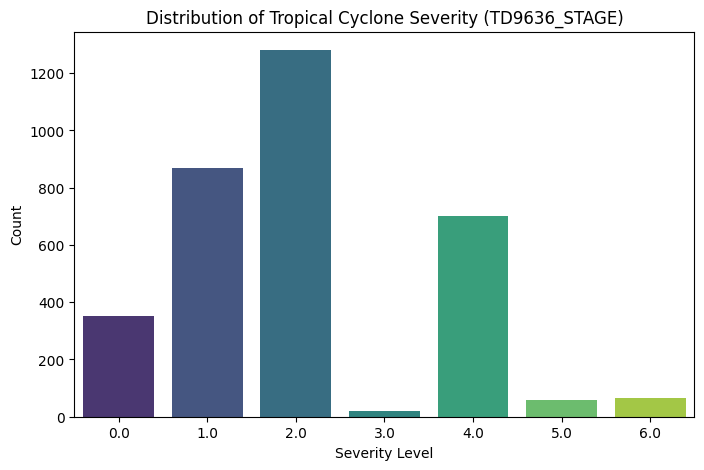

In [36]:

# Plot distribution of the target variable (TD9636_STAGE)
plt.figure(figsize=(8, 5))
sns.countplot(x=df_chunk["TD9636_STAGE"], palette="viridis")
plt.title("Distribution of Tropical Cyclone Severity (TD9636_STAGE)")
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


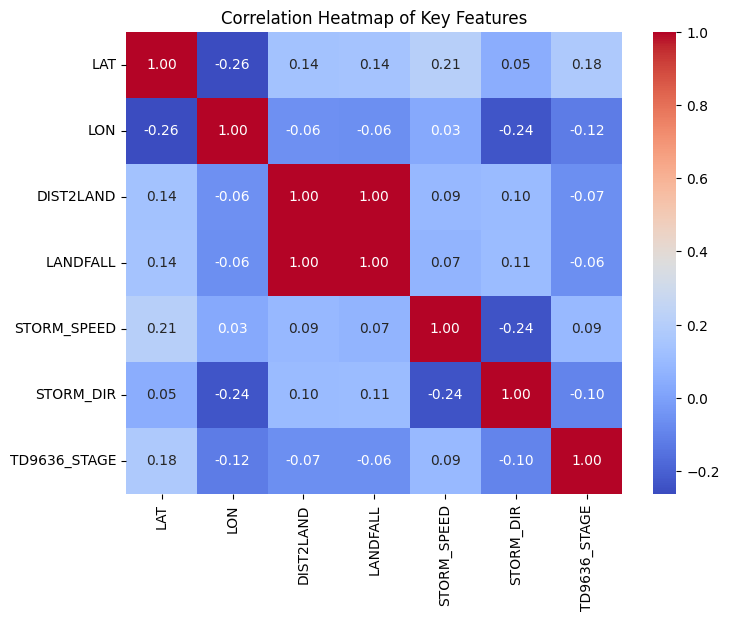

In [7]:

# Plot correlation heatmap for numerical features
plt.figure(figsize=(8, 6))
sns.heatmap(df_chunk[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Key Features")
plt.show()


In [37]:

# Convert ISO_TIME to datetime format and extract features
df_chunk["ISO_TIME"] = pd.to_datetime(df_chunk["ISO_TIME"], errors="coerce")

# Extract year, month, and hour
df_chunk["YEAR"] = df_chunk["ISO_TIME"].dt.year
df_chunk["MONTH"] = df_chunk["ISO_TIME"].dt.month
df_chunk["HOUR"] = df_chunk["ISO_TIME"].dt.hour

# Normalize DIST2LAND using MinMaxScaler
scaler = MinMaxScaler()
df_chunk["DIST2LAND_NORM"] = scaler.fit_transform(df_chunk[["DIST2LAND"]])

# Drop original ISO_TIME column
df_chunk = df_chunk.drop(columns=["ISO_TIME"])

# Display updated dataset structure
df_chunk.head()


,SID,SEASON,NATURE,LAT,LON,WMO_PRES,DIST2LAND,LANDFALL,USA_AGENCY,USA_ATCF_ID,USA_LAT,USA_LON,USA_RECORD,USA_STATUS,USA_WIND,USA_PRES,USA_SSHS,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,USA_R50_NE,USA_R50_SE,USA_R50_SW,USA_R50_NW,USA_R64_NE,USA_R64_SE,USA_R64_SW,USA_R64_NW,USA_POCI,USA_ROCI,USA_RMW,USA_EYE,TOKYO_LAT,TOKYO_LON,TOKYO_GRADE,TOKYO_WIND,TOKYO_PRES,TOKYO_R50_DIR,TOKYO_R50_LONG,TOKYO_R50_SHORT,TOKYO_R30_DIR,TOKYO_R30_LONG,TOKYO_R30_SHORT,TOKYO_LAND,CMA_LAT,CMA_LON,CMA_CAT,CMA_WIND,CMA_PRES,HKO_LAT,HKO_LON,HKO_CAT,HKO_WIND,HKO_PRES,KMA_LAT,KMA_LON,KMA_CAT,KMA_WIND,KMA_PRES,KMA_R50_DIR,KMA_R50_LONG,KMA_R50_SHORT,KMA_R30_DIR,KMA_R30_LONG,KMA_R30_SHORT,NEWDELHI_LAT,NEWDELHI_LON,NEWDELHI_GRADE,NEWDELHI_WIND,NEWDELHI_PRES,NEWDELHI_CI,NEWDELHI_DP,NEWDELHI_POCI,REUNION_LAT,REUNION_LON,REUNION_TYPE,REUNION_WIND,REUNION_PRES,REUNION_TNUM,REUNION_CI,REUNION_RMW,REUNION_R34_NE,REUNION_R34_SE,REUNION_R34_SW,REUNION_R34_NW,REUNION_R50_NE,REUNION_R50_SE,REUNION_R50_SW,REUNION_R50_NW,REUNION_R64_NE,REUNION_R64_SE,REUNION_R64_SW,REUNION_R64_NW,BOM_LAT,BOM_LON,BOM_TYPE,BOM_WIND,BOM_PRES,BOM_TNUM,BOM_CI,BOM_RMW,BOM_R34_NE,BOM_R34_SE,BOM_R34_SW,BOM_R34_NW,BOM_R50_NE,BOM_R50_SE,BOM_R50_SW,BOM_R50_NW,BOM_R64_NE,BOM_R64_SE,BOM_R64_SW,BOM_R64_NW,BOM_ROCI,BOM_POCI,BOM_EYE,BOM_POS_METHOD,NADI_LAT,NADI_LON,NADI_CAT,NADI_WIND,NADI_PRES,WELLINGTON_LAT,WELLINGTON_LON,WELLINGTON_WIND,WELLINGTON_PRES,DS824_LAT,DS824_LON,DS824_WIND,DS824_PRES,TD9636_LAT,TD9636_LON,TD9636_STAGE,TD9636_PRES,TD9635_LAT,TD9635_LON,TD9635_WIND,TD9635_PRES,TD9635_ROCI,NEUMANN_LAT,NEUMANN_LON,NEUMANN_WIND,NEUMANN_PRES,MLC_LAT,MLC_LON,MLC_CLASS,MLC_WIND,MLC_PRES,USA_GUST,BOM_GUST,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR,YEAR,MONTH,HOUR,DIST2LAND_NORM
0,1980001S13173,1980,TS,-12.5,172.5,,647,647.0,jtwc_sh,SH051980,-12.5,172.5,,,25,,-1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-12.5,172.5,25,,-12.5,172.5,1.0,,,,,,,-12.5,172.5,25,,,,,,,,,,,,,,,,,6,350,1980,1,0,0.210133
1,1980001S13173,1980,TS,-12.2,172.4,,653,653.0,,SH051980,-12.2,172.4,,,25,,-1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-12.2,172.4,25,,-12.2,172.5,1.0,,,,,,,-12.2,172.4,25,,,,,,,,,,,,,,,,,6,350,1980,1,3,0.212082
2,1980001S13173,1980,TS,-11.9,172.4,,670,670.0,jtwc_sh,SH051980,-11.9,172.4,,,25,,-1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-11.9,172.4,25,,-12.0,172.4,1.0,,,,,,,-11.9,172.4,25,,,,,,,,,,,,,,,,,5,360,1980,1,6,0.217603
3,1980001S13173,1980,TS,-11.7,172.4,,682,682.0,,SH051980,-11.7,172.4,,,25,,-1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-11.7,172.4,25,,-11.7,172.5,1.0,,,,,,,-11.7,172.4,25,,,,,,,,,,,,,,,,,4,10,1980,1,9,0.221500
4,1980001S13173,1980,TS,-11.5,172.5,,703,703.0,jtwc_sh,SH051980,-11.5,172.5,,,25,,-1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-11.5,172.5,25,,-11.5,172.5,1.0,,,,,,,-11.5,172.5,25,,,,,,,,,,,,,,,,,4,20,1980,1,12,0.228321


In [38]:

# Define features and target variable
features = ["LAT", "LON", "DIST2LAND_NORM", "STORM_SPEED", "STORM_DIR", "MONTH", "HOUR"]
target = "TD9636_STAGE"

# Drop rows where target variable is missing
df_chunk = df_chunk.dropna(subset=[target])
df_chunk[target] = df_chunk[target].astype(int)

# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(df_chunk[features], df_chunk[target], test_size=0.2, random_state=42)

# Train Decision Tree Classifier (Baseline Model)
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb_model.fit(X_train, y_train)

# Predict using all models
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
dt_acc = accuracy_score(y_test, y_pred_dt)
rf_acc = accuracy_score(y_test, y_pred_rf)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

# Print Accuracy Scores
print("Decision Tree Accuracy:", dt_acc)
print("Random Forest Accuracy:", rf_acc)
print("XGBoost Accuracy:", xgb_acc)


C:\Users\FAVOUR\anaconda3\envs\exam\lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Decision Tree Accuracy: 0.8624813153961136
Random Forest Accuracy: 0.929745889387145
XGBoost Accuracy: 0.9103139013452914


In [39]:

# Generate classification report for XGBoost model
xgb_report = classification_report(y_test, y_pred_xgb)
print("XGBoost Classification Report:\n", xgb_report)

# Save the best model (XGBoost)
model_path = "xgboost_tropical_cyclone.pkl"
joblib.dump(xgb_model, model_path)

# Export predictions
predictions_df = X_test.copy()
predictions_df["Actual"] = y_test
predictions_df["Predicted"] = y_pred_xgb
predictions_file = "cyclone_predictions.csv"
predictions_df.to_csv(predictions_file, index=False)

print(f"Model saved to: {model_path}")
print(f"Predictions saved to: {predictions_file}")


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        76
           1       0.94      0.87      0.90       179
           2       0.87      0.93      0.90       254
           3       0.67      0.40      0.50         5
           4       0.91      0.92      0.92       139
           5       1.00      0.75      0.86         8
           6       1.00      0.75      0.86         8

    accuracy                           0.91       669
   macro avg       0.91      0.80      0.85       669
weighted avg       0.91      0.91      0.91       669

Model saved to: xgboost_tropical_cyclone.pkl
Predictions saved to: cyclone_predictions.csv


In [40]:
predictions = pd.read_csv("cyclone_predictions.csv")
print(predictions.head())

    LAT    LON  DIST2LAND_NORM  STORM_SPEED  STORM_DIR  MONTH  HOUR  Actual  \
0 -13.6   55.6        0.187399           11        265      3    18       2   
1  10.1  139.9        0.421890           18        275      7    12       2   
2  20.0  124.0        0.081845            7         70      5    12       4   
3 -15.4  177.6        0.056512           13        130      3    15       2   
4 -18.4  116.5        0.079896           11        305      3    21       1   

   Predicted  
0          2  
1          1  
2          4  
3          2  
4          1  


In [41]:
import joblib

# Load the trained XGBoost model
model = joblib.load("xgboost_tropical_cyclone.pkl")

# Check if feature names are stored in the model
if hasattr(model, "feature_names_in_"):
    print("Trained Features:", model.feature_names_in_)
else:
    print("Feature names not stored in the model.")


Trained Features: ['LAT' 'LON' 'DIST2LAND_NORM' 'STORM_SPEED' 'STORM_DIR' 'MONTH' 'HOUR']


In [42]:
# Convert DIST2LAND to numeric (force errors to NaN)
df_chunk["DIST2LAND"] = pd.to_numeric(df_chunk["DIST2LAND"], errors='coerce')

# Now check min and max
print("DIST2LAND Min:", df_chunk["DIST2LAND"].min())
print("DIST2LAND Max:", df_chunk["DIST2LAND"].max())


DIST2LAND Min: 0
DIST2LAND Max: 3079


In [43]:
# Check class distribution in training data



df = pd.read_csv(file_path, usecols=["TD9636_STAGE"])  # Use the correct column name
print(df["TD9636_STAGE"].value_counts())


TD9636_STAGE
     248756
2     17204
1     16028
4     10623
0      3156
3       742
5       331
6       259
Name: count, dtype: int64


In [46]:
model = joblib.load("xgboost_tropical_cyclone.pkl")

# Get feature importances
importances = model.feature_importances_
features = ['LAT', 'LON', 'DIST2LAND_NORM', 'STORM_SPEED', 'STORM_DIR', 'MONTH', 'HOUR']

# Display feature importance
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print(importance_df)

          Feature  Importance
5           MONTH    0.213593
0             LAT    0.185578
1             LON    0.164414
2  DIST2LAND_NORM    0.136624
4       STORM_DIR    0.119422
3     STORM_SPEED    0.111389
6            HOUR    0.068981


In [45]:
import os

model_path = "xgboost_tropical_cyclone.pkl"

# Check if the file exists in the current directory
if os.path.exists(model_path):
    print(f"Model found at: {os.path.abspath(model_path)}")
else:
    print("Model not found in the current directory. Searching...")

    # Search for the model file in the entire system (this might take time)
    for root, dirs, files in os.walk("/"):
        if model_path in files:
            print(f"Model found at: {os.path.join(root, model_path)}")
            break


Model found at: C:\Users\FAVOUR\Desktop\Python project\tropical-cyclones\xgboost_tropical_cyclone.pkl
